In [1]:
!pip install dtw-python

In [2]:
pip install netdata-pandas==0.0.15 tslearn==0.4.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /opt/anaconda3/lib/python3.8/site-packages (2.6.0)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


<h1><center> Water quality forecasting </center></h1> 

## TOC:
* [Introduction](#first-bullet)
* [Exploratory Data Analysis](#second-bullet)
* [Water Quality Index](#third-bullet)
* [Data preparation](#forth-bullet)
* [Linear Regression](#fifth-bullet)
* [LSTM](#sixth-bullet)
* [Conclusion](#seventh-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

Pivdennyi Buh is the second largest river in Ukraine. The river runs almost accross the whole country from North-West to the South of the country and flows into the Black sea. It is one of the main sources of fresh water of that region and is used for agricultural purposes. Hence, it is highly important to monitor the quality of the water.

<img src="Pivdennyi_buh.png">

In the dataset (https://www.kaggle.com/vbmokin/wq-southern-bug-river-01052021) the water quality of Pivdennyi Buh river has been measured over 20 years on 22 stations based on 8 parameters: 

**Biological Oxygen Demand (BSK5)** describes the amount of pollution present in water. Higher BOD signifies lower water quality. Lower BOD means less oxygen is being removed from water, so water is generally purer. 

Most pristine rivers will have a 5-day carbonaceous BOD below 1 mg/L. Moderately polluted rivers may have a BOD value in the range of 2 to 8 mg/L. Rivers may be considered severely polluted when BOD values exceed 8 mg/L.

High biochemical oxygen demand can be caused by:
* high levels of organic pollution, caused usually by poorly treated wastewater;
* high nitrate levels, which trigger high plant growth.

Reference: https://en.wikipedia.org/wiki/Biochemical_oxygen_demand

**Ammonia (NH4)** is a nitrogen-containing nutrient for plant growth. Natural sources of ammonia include the decomposition or breakdown of organic waste matter, gas exchange with the atmosphere, forest fires, animal and human waste, and nitrogen fixation processes.

High concentration of ammonia means a toxic environment and causes lower reproduction and growth or death.
The acceptable concentration of ammonia is less than or equal to 0.5 mg/l.

Reference: https://sibkif.ru/normy/norma-ammiaka-v-pitevoj-vode.html

**Dissolved oxygen (O2)** is an essentail component for the aquatic life. Natural lakes and rivers
generally cannot have too much oxygen. In polluted systems, overgrowth of animals, plants and bacteria cause
the oxygen to be used up quickly, sometimes causing fish to suffocate.

<img src="oxygen_range.png">

As it can be seen from the image, the value of dissolved oxygen between 9.5 - 12 mg/l detemines clean water and the range of 6.5 - 9.5 mg/l is still considered to be acceptable. Whereas, lower values detemine polluted environment.

Reference: https://www.enr.gov.nt.ca/sites/enr/files/dissolved_oxygen.pdf

**Nitrate (NO3 and NO2)** is a compound that is formed naturally when nitrogen combines with oxygen or ozone. Ammonia can be converted to nitrite (NO2 ) and nitrate (NO3) by bacteria, and then used by plants. Nitrate predominates in unpolluted waters. 

The nitrate concentration in surface water is normally low (0–18 mg/l). Nitrite levels in drinking-water are usually below 0.1 mg/l.

Reference: https://www.who.int/water_sanitation_health/dwq/chemicals/nitratenitrite2ndadd.pdf

**Suspended substances** in water are often due to the natural causes. The natural solids include organic materials such as algae, and inorganic materials such as silt and sediment. When suspended solids exceed expected concentrations, they can negatively impact a body of water. Excess over background amounts are often attributed to human influence, whether directly or indirectly. Table below represents the quality of water based on solids concentration.

| Water quality | Concentration |
| :-  | --- |
| Excellent | < 300 mg/l |
| Good | 300 - 600 mg/l |
| Fair | 600 - 900 mg/l |
| Poor | 900 - 1200 mg/l |
| Unacceptable | > 1200 mg/l |

Reference: https://www.who.int/water_sanitation_health/dwq/chemicals/tds.pdf

**Phosphates (PO4)** do not cause health problems except for very high concentrations. In general, concentrations over 0.05 will likely have an impact while concentrations greater than 0.1 mg/L will certainly have impact on a river.

Reference: https://www.watertechonline.com/home/article/15540707/phosphates

With that, in this study the quality of the water will be measured based on BOD, Ammonia and Dissolved Oxygen parameters, as they are considered to be the main sources of information about the state of the water body.

## Exploratory Data Analysis <a class="anchor" id="second-bullet"></a>

In [6]:
# Import libraries
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, GridSearchCV

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv1D

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from keras import backend as K
import statsmodels.stats.api as sms

We start by fetching the data. The 'indicators_data' contains observation components for each sample and 'stations' contains information about stations.

In [7]:
indicators_data = pd.read_csv('data/PB_All_2000_2021.csv',  delimiter=';')
indicators_data.head(10)

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.500,0.057,154.0,0.454,289.5
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.750,0.034,352.0,0.090,1792.0
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.800,0.173,416.0,0.200,2509.0
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.130,0.099,275.2,0.377,1264.0
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.000,0.065,281.6,0.134,1462.0
5,1,07.06.2001,0.020,4.02,34.0,10.61,11.800,0.016,287.0,0.208,1183.0
6,1,10.09.2001,0.863,3.91,147.0,10.96,20.500,0.284,595.2,0.674,4023.0
7,1,06.11.2001,0.060,2.97,71.2,13.47,25.800,0.095,314.0,0.390,1907.0
8,1,12.03.2002,0.168,4.15,27.0,17.82,3.945,0.058,153.6,0.110,473.0
9,1,06.06.2002,0.001,7.11,74.4,19.28,2.260,0.017,409.6,0.181,1782.0


In [8]:
stations = pd.read_csv('data/PB_stations.csv',  sep=';', header=0, encoding='cp1251')
# stations.sort_values(by=['length'], ascending=False)
stations.head(10)

,id,length,name_station
0,1,0.5,"р. Південний Буг, 0,5 км, м. Миколаїв, Бузький..."
1,2,136.0,"р. Південний Буг, 136 км, с. Олександрівка, Ол..."
2,3,153.0,"р. Південний Буг, 153 км, с. Олексіівка, питни..."
3,4,206.0,"р. Південний Буг, 206 км, м. Первомайськ, Перв..."
4,5,237.0,"р. Південний Буг, 237 км, питний водозабір смт..."
5,6,316.0,"р. Південний Буг, 316 км, м.Гайворон, Гайворон..."
6,7,327.0,"р. Південний Буг, 327 км, с. Ставки, кордон Ві..."
7,8,372.0,"р. Південний Буг, 372 км, с. Глибочок, Глибоче..."
8,9,400.0,"р. Південний Буг, 400 км, м. Ладижин, Ладижинс..."
9,10,413.0,"р. Південний Буг, 413 км, с. Маньківка, вище с..."


In [9]:
indicators_data['ds'] = pd.to_datetime(indicators_data['date'])
indicators_data['year'] = indicators_data['ds'].dt.year
indicators_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         2861 non-null   int64         
 1   date       2861 non-null   object        
 2   NH4        2858 non-null   float64       
 3   BSK5       2860 non-null   float64       
 4   Suspended  2845 non-null   float64       
 5   O2         2858 non-null   float64       
 6   NO3        2860 non-null   float64       
 7   NO2        2858 non-null   float64       
 8   SO4        2812 non-null   float64       
 9   PO4        2833 non-null   float64       
 10  CL         2812 non-null   float64       
 11  ds         2861 non-null   datetime64[ns]
 12  year       2861 non-null   int64         
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 290.7+ KB


Next we want to find out when was the start and final years of observations for each station.

In [10]:
start_year = indicators_data[['id', 'year']].groupby(by=['id']).min().sort_values(by=['year'], ascending=False)
end_year = indicators_data[['id', 'year']].groupby(by=['id']).max().sort_values(by=['year'], ascending=False)

years = pd.concat([start_year, end_year],axis=1)
years.columns = ['start_year', 'end_year']
years

,start_year,end_year
id,,
1,2000,2018
2,2000,2018
3,2000,2021
4,2000,2018
5,2019,2021
6,2000,2018
7,2000,2018
8,2000,2018
9,2000,2018


We can see that the observations for all stations, except for 13 and 5, start in 2000 and not all stations are up to date. Stations 14, 15, 16 will be considered further, as it is the longest sequence of stations with the most recent information.

In [11]:
stations_considered = [14, 15, 16]
# Set target indicatorc(edit)
target_data_name = 'O2'
feature_target_all = ['BSK5', 'NH4', 'SO4', 'NO2', 'NO3', 'CL', 'Suspended']
feature_data_all = feature_target_all + [target_data_name]

Sampling the data only for considered stations.

In [12]:
df_indicator = indicators_data[['id', 'ds'] + feature_data_all]
df_indicator = df_indicator[df_indicator['id'].isin(stations_considered)].dropna().reset_index(drop=True)
df_indicator

,id,ds,BSK5,NH4,SO4,NO2,NO3,CL,Suspended,O2
0,14,2000-10-01,1.9,1.30,40.1,0.300,6.30,31.3,9.0,15.8
1,14,2000-01-02,2.5,2.20,27.8,0.270,8.80,31.3,8.0,10.6
2,14,2000-01-03,4.1,0.68,45.8,0.090,8.80,28.6,11.0,10.3
3,14,2000-04-04,3.4,0.81,47.4,0.090,4.60,23.2,13.0,8.7
4,14,2000-05-16,3.0,0.27,22.9,0.050,3.00,23.2,10.0,6.5
...,...,...,...,...,...,...,...,...,...,...
757,16,2020-06-10,5.6,0.28,15.7,0.100,1.90,44.0,12.0,6.2
758,16,2020-03-11,6.2,0.07,26.8,0.044,2.06,35.5,9.0,7.1
759,16,2020-08-12,5.6,0.17,31.0,0.060,3.38,40.3,13.0,6.8
760,16,2021-03-16,4.4,2.29,32.8,6.790,7.70,36.1,9.0,7.7


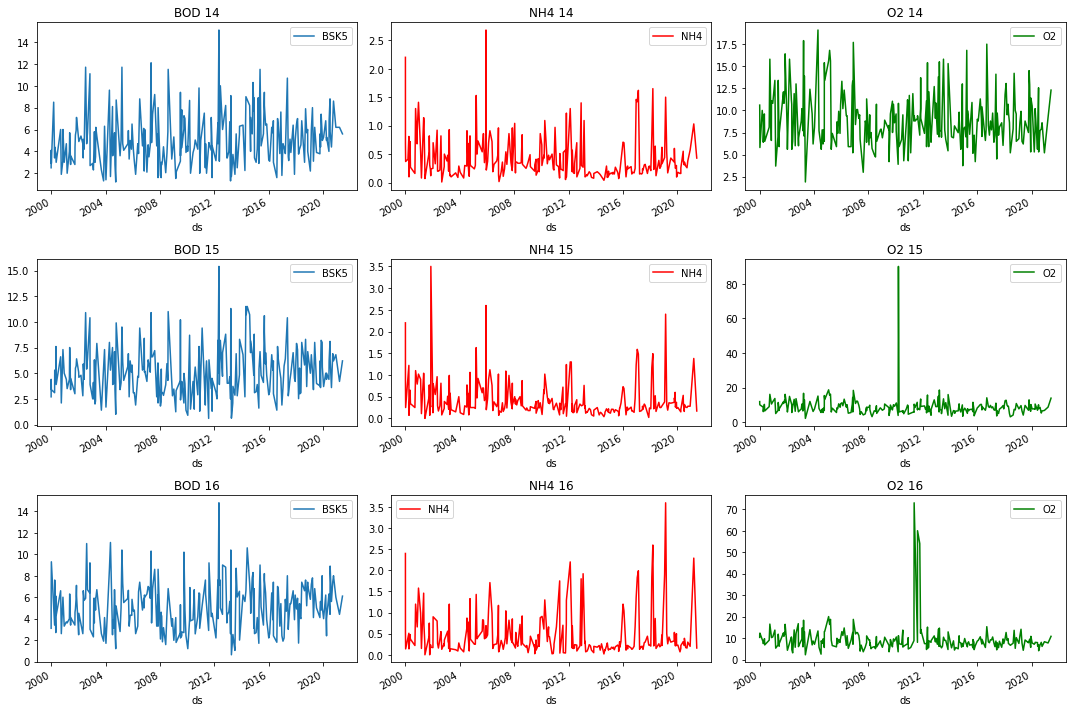

In [13]:
fig, axs = plt.subplots(3, 3,figsize=(15,10))
df_indicator.loc[(df_indicator.id == 14)].plot(x='ds', y='BSK5', ax=axs[0,0]).set_title("BOD 14")
df_indicator.loc[(df_indicator.id == 14)].plot(x='ds', y='NH4', color='red', ax=axs[0,1]).set_title("NH4 14")
df_indicator.loc[(df_indicator.id == 14)].plot(x='ds', y='O2', color='green', ax=axs[0,2]).set_title("O2 14")

df_indicator.loc[(df_indicator.id == 15)].plot(x='ds', y='BSK5', ax=axs[1,0]).set_title("BOD 15")
df_indicator.loc[(df_indicator.id == 15)].plot(x='ds', y='NH4', color='red', ax=axs[1,1]).set_title("NH4 15")
df_indicator.loc[(df_indicator.id == 15)].plot(x='ds', y='O2', color='green', ax=axs[1,2]).set_title("O2 15")

df_indicator.loc[(df_indicator.id == 16)].plot(x='ds', y='BSK5', ax=axs[2,0]).set_title("BOD 16")
df_indicator.loc[(df_indicator.id == 16)].plot(x='ds', y='NH4', color='red', ax=axs[2,1]).set_title("NH4 16")
df_indicator.loc[(df_indicator.id == 16)].plot(x='ds', y='O2', color='green', ax=axs[2,2]).set_title("O2 16")
fig.tight_layout()

## Water Quality Index <a class="anchor" id="third-bullet"></a>

**Water Quality Index** is one of the most efficient methods to measure the quality of water. Number of chemical parameters are included in the calculations to detemine the suitability of water for drinking.

**Computation of WQI**:

**First step** – Assigning of weight ($w_i$) to the selected water parameters according to their relative importance in the overall quality of water for drinking purposes (weight may be from 1 to 5).

**Second step** – Computation of a relative weight ($W_i$) of the chemical parameter:                                                                                
$$ W_i = \frac{w_i}{\Sigma_1^n  w_i}$$

where, $W_i$ is the relative weight, $w_i$ is the weight of each parameter and n is the number of parameters

**Third step** - Assigning of a quality rating scale ($q_i$) for each parameter:
$$ q_i = \frac{C_i}{S_i}* 100  $$

where,  $q_i$ is the quality rating, $C_i$ is the concentration of each chemical parameter in each water sample in mg/l, and $S_i$ is the guide line value/desirable limit.
For computation of  WQI, the sub index (SI) is first determined for each chemical parameter:                                                                            
$$ SI_i = W_i * q_i $$
$$ WQI = \Sigma_1^n SI_i $$

where, $SI_i$ is the subindex of ith parameter; $W_i$ is relative weight of ith parameter; $q_i$ is the rating based on concentration of ith parameter and n is the number of chemical parameters.

The water may be classified into five types based on computed WQI as given below:
* < 50: Excellent water;
* 50 - 100: Good water;
* 100- 200: Poor water;
* 200 – 300: Very poor water;
* \> 300: Water unsuitable for drinking.

The weight for each parameter was based on the work of (Batabyal A. K., Chakraborty S. Hydrogeochemistry and water quality index in the assessment of groundwater quality for drinking uses //Water Environment Research. – 2015. – Т. 87. – №. 7. – С. 607-617.)

|Chemical parameter| Standard | Weight ($w_i$) | Relative weight ($W_i$) |
| :-  | --- | --- | --- |
| Biological oxygen deman | 0 - 5 | 3 | 0.1 |
| Ammonia | 0 - 0.5 | 4 | 0.133 |
| Dissolved oxygen | 6.5 - 12 | 4 | 0.133 |
| Nitrate | 0 - 18 | 5 | 0.167 |
| Nitrite | 0 - 0.1 | 3 | 0.1 |
| Chloride | 250 - 1000 | 3 | 0.1 |
| Sulphate | 200 - 400 | 4 | 0.133 |
| Suspended solids | 0 - 600 | 4 | 0.133|
|  |  | $ \Sigma w_i = $ 30 | $\Sigma W_i = $  1.00|

In [14]:
def get_wqi(data_old):
    data = data_old.copy()
    data['BSK5'] = ((data['BSK5']/5)*100)*0.1
    data['NH4'] = ((data['NH4']/0.5)*100)*0.133
    data['O2'] = ((data['O2']/12)*100)*0.133
    data['NO3'] = ((data['NO3']/18)*100)*0.167
    data['NO2'] = ((data['NO2']/0.1)*100)*0.1
    data['CL'] = ((data['CL']/100)*100)*0.1
    data['SO4'] = ((data['SO4']/400)*100)*0.133
    data['Suspended'] = ((data['Suspended']/600)*100)*0.133
    data["WQI"] = data.sum(axis=1)
    return data

In [15]:
df_wqi = get_wqi(df_indicator)
df_wqi

,id,ds,BSK5,NH4,SO4,NO2,NO3,CL,Suspended,O2,WQI
0,14,2000-10-01,3.8,34.580,1.333325,30.0,5.845000,3.13,0.199500,17.511667,110.399492
1,14,2000-01-02,5.0,58.520,0.924350,27.0,8.164444,3.13,0.177333,11.748333,128.664461
2,14,2000-01-03,8.2,18.088,1.522850,9.0,8.164444,2.86,0.243833,11.415833,73.494961
3,14,2000-04-04,6.8,21.546,1.576050,9.0,4.267778,2.32,0.288167,9.642500,69.440494
4,14,2000-05-16,6.0,7.182,0.761425,5.0,2.783333,2.32,0.221667,7.204167,45.472592
...,...,...,...,...,...,...,...,...,...,...,...
757,16,2020-06-10,11.2,7.448,0.522025,10.0,1.762778,4.40,0.266000,6.871667,58.470469
758,16,2020-03-11,12.4,1.862,0.891100,4.4,1.911222,3.55,0.199500,7.869167,49.082989
759,16,2020-08-12,11.2,4.522,1.030750,6.0,3.135889,4.03,0.288167,7.536667,53.743472
760,16,2021-03-16,8.8,60.914,1.090600,679.0,7.143889,3.61,0.199500,8.534167,785.292156


In [16]:
df_wqi = df_wqi.set_index('ds')
df_wqi['Year'] = df_wqi.index.year
df_wqi['Month'] = df_wqi.index.month
df_wqi['Day'] = df_wqi.index.day

Text(0.5, 1.0, 'WQI station 16')

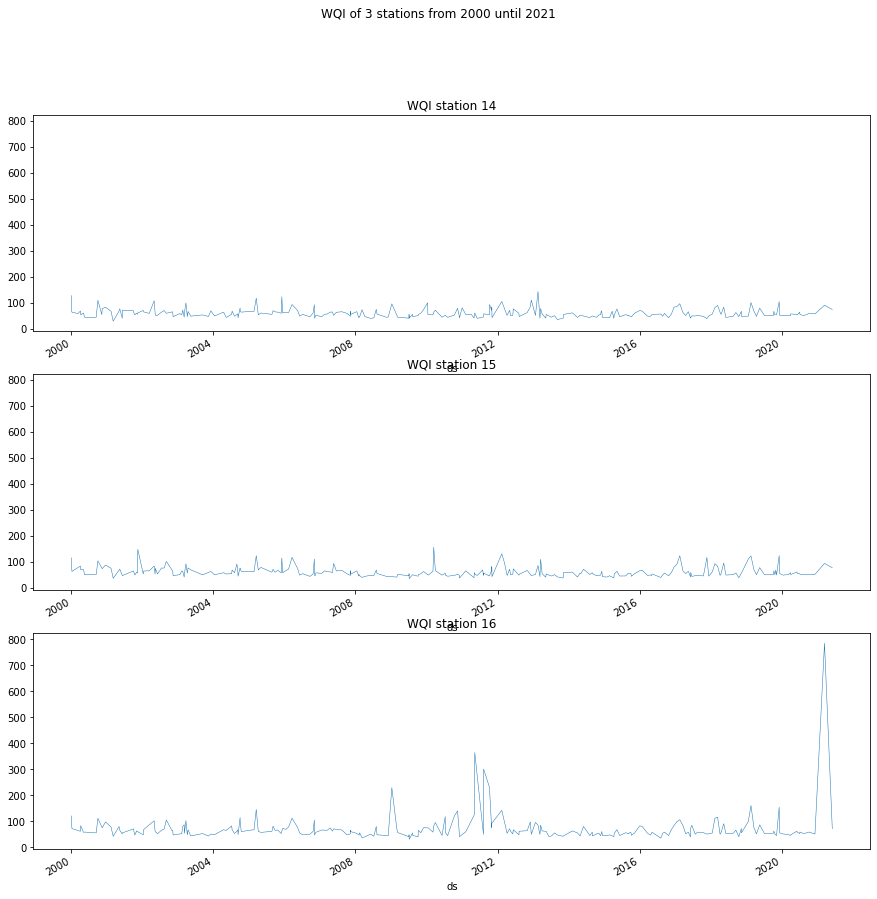

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
fig.suptitle('WQI of 3 stations from 2000 until 2021')

# sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)
df_wqi[df_wqi['id']==14]['WQI'].plot(linewidth=0.5, ax=axes[0])
axes[0].set_title('WQI station 14')
df_wqi[df_wqi['id']==15]['WQI'].plot(linewidth=0.5, ax=axes[1])
axes[1].set_title('WQI station 15')
df_wqi[df_wqi['id']==16]['WQI'].plot(linewidth=0.5, ax=axes[2])
axes[2].set_title('WQI station 16')

We can see that there is some outlier in station 16 in the year of 2021. Hence, the data will be only considered until 2020.

Text(0.5, 1.0, 'WQI station 16')

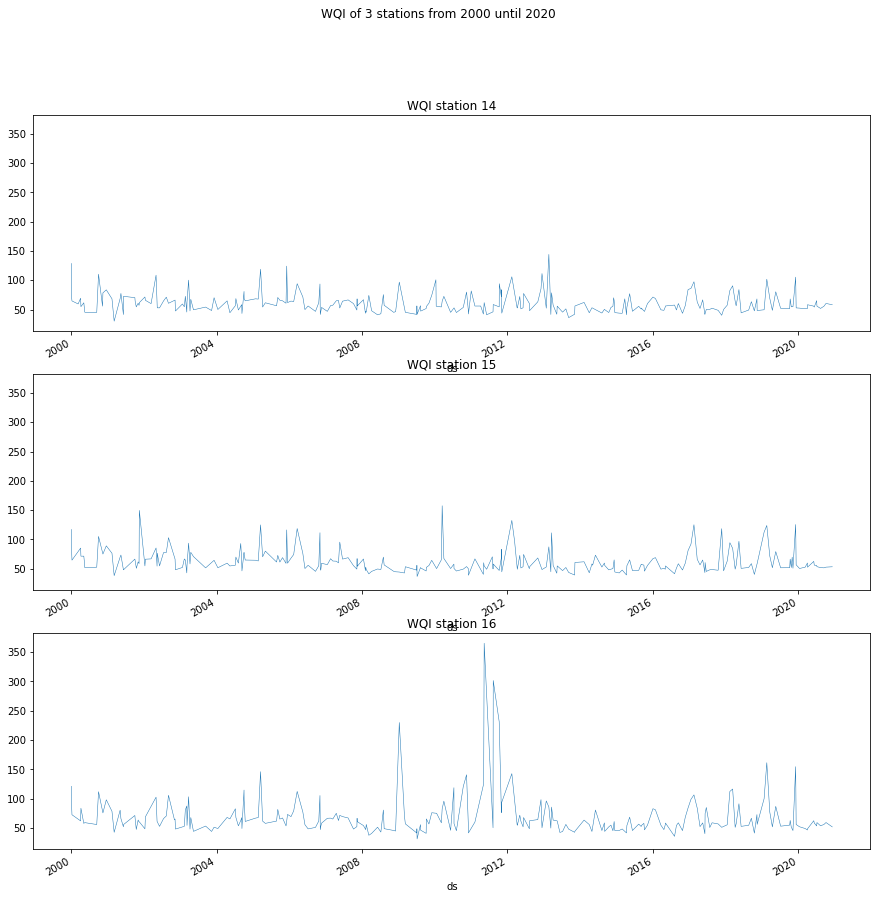

In [18]:
df_wqi = df_wqi[df_wqi['Year'] < 2021]

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
fig.suptitle('WQI of 3 stations from 2000 until 2020')
df_wqi[df_wqi['id']==14]['WQI'].plot(linewidth=0.5, ax=axes[0])
axes[0].set_title('WQI station 14')
df_wqi[df_wqi['id']==15]['WQI'].plot(linewidth=0.5, ax=axes[1])
axes[1].set_title('WQI station 15')
df_wqi[df_wqi['id']==16]['WQI'].plot(linewidth=0.5, ax=axes[2])
axes[2].set_title('WQI station 16')

From the plots above we can say that the WQI of Pivdeniy Bug river on stations 14, 15, 16 is relatively good in general. Also the river is getting polluted seasonally. This could happen due to an electrical and a nuclear stations based on that river. 

## Data preparation <a class="anchor" id="forth-bullet"></a>

As we chose the stations, we want to change the dataset to get a better look at the data.

In [19]:
cols = []
features_considered = ['WQI']
for station in stations_considered:
    for feature in features_considered:
        cols.append(str(station) + "_" + feature)
cols

['14_WQI', '15_WQI', '16_WQI']

In [20]:
df = pd.pivot_table(df_wqi, index=["ds"], columns=["id"], values=features_considered).dropna()
df.columns = cols
df

,14_WQI,15_WQI,16_WQI
ds,,,
2000-01-02,128.664461,117.079650,121.130922
2000-01-03,73.494961,88.187444,94.481111
2000-01-08,64.812975,64.792586,72.590667
2000-04-04,69.440494,85.314161,62.121622
2000-04-07,55.018022,71.568467,83.754822
...,...,...,...
2020-07-07,55.885164,53.642829,59.272691
2020-08-12,52.034678,52.080978,53.743472
2020-09-15,55.717219,51.635392,56.045117


From the table above (and the plots) it is known that usually the values for 3 stations do not vary much on one observation.

The next step is to change the data to a supervised learning problem. We are condering values from stations 14 and 15 as input to the model, in order to predict the value of a station 16.

In [21]:
x1, x2, y = df['14_WQI'], df['15_WQI'], df['16_WQI']
x1, x2, y = np.array(x1), np.array(x2), np.array(y)
x1, x2, y = x1.reshape(-1, 1), x2.reshape(-1, 1), y.reshape(-1, 1)
final_x = np.concatenate((x1, x2), axis=1)

Dividing data into train and test sets. Reserving last 69 values to test set.

In [22]:
X_train, X_test, y_train, y_test = final_x[:-69], final_x[-69:], y[:-69], y[-69:]

## Linear Regression <a class="anchor" id="fifth-bullet"></a>

In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

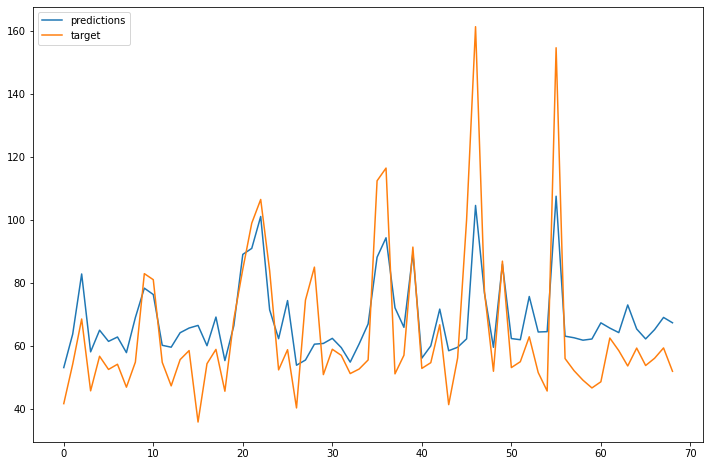

In [24]:
lr_preds = lr_model.predict(X_test)
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(lr_preds, label="predictions")
plt.plot(y_test, label="target")
plt.legend(loc="upper left")
plt.show()

In [25]:
rmse_lr = np.sqrt(mean_squared_error(lr_preds, y_test))
r2_lr = round(r2_score(y_test, lr_preds), 2)
print("RMSE Linear regression: ", rmse_lr)
print("R2 score Linear regression: ", r2_lr)
adjusted_r_squared = 1 - (1-r2_lr)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("Adjusted R2: ", adjusted_r_squared)

RMSE Linear regression:  15.372861486031706
R2 score Linear regression:  0.58
Adjusted R2:  0.5672727272727273


In [26]:
print("Target values confidence interval: ", sms.DescrStatsW(y_test).tconfint_mean())
print("Prediction values confidence interval: ", sms.DescrStatsW(lr_preds).tconfint_mean())

Target values confidence interval:  (array([58.56467787]), array([70.00645435]))
Prediction values confidence interval:  (array([65.32500091]), array([71.14605901]))


In [27]:
scores = cross_val_score(lr_model, X_test, y_test, cv=5)
scores

array([ 0.82516375,  0.53382091,  0.17821724,  0.78342551, -0.9154323 ])

## LSTM <a class="anchor" id="sixth-bullet"></a>

Since keras LSTM model accepts the data of a certain shape, we have to reshape it to fit the model.

In [32]:
df_stacked = df.stack()

In [33]:
values = df_stacked.values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [34]:
train_size = int(len(scaled)*0.9)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

Convert series to supervised learning problem

In [35]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [36]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [37]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

LSTM model with 200 neurons and activation function as ReLU. The model is trained for 300 epochs.

In [38]:
import keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [39]:
import tensorflow as tf
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=[soft_acc])
# model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.Accuracy()])

In [40]:
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

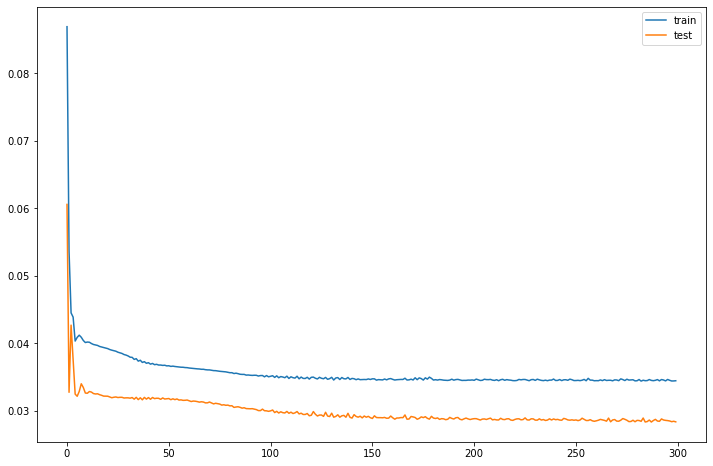

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
preds = model.predict(testX, verbose=0)

In [43]:
testY = testY.reshape(-1,1)
model_preds = scaler.inverse_transform(preds)
target = scaler.inverse_transform(testY)

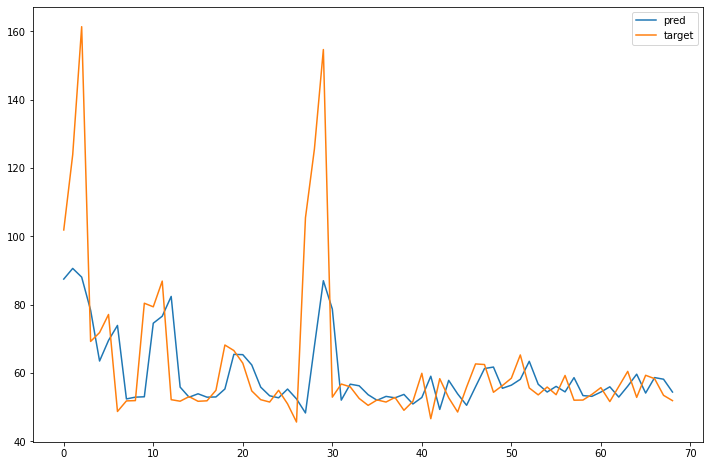

In [44]:
plt.plot(model_preds, label="pred")
plt.plot(target, label='target')
plt.legend()
plt.show()

In [45]:
rmse_lstm = np.sqrt(mean_squared_error(target, model_preds))
r2_lstm = round(r2_score(target, model_preds), 2)
print("RMSE LSTM: ", rmse_lstm)
print("R2 score LSTM: ", r2_lstm)
adjusted_r_squared = 1 - (1-r2_lstm)*(len(testY)-1)/(len(testY)-testX.shape[1]-1)
print("Adjusted R2: ", adjusted_r_squared)

RMSE LSTM:  18.014637
R2 score LSTM:  0.37
Adjusted R2:  0.35090909090909084


In [46]:
print("Target values confidence interval: ", sms.DescrStatsW(target).tconfint_mean())
print("Prediction values confidence interval: ", sms.DescrStatsW(model_preds).tconfint_mean())

Target values confidence interval:  (array([57.64123522]), array([68.63151807]))
Prediction values confidence interval:  (array([57.25345563]), array([62.18283826]))


## Conclusion <a class="anchor" id="seventh-bullet"></a>


| Model| RMSE | R2 | Adjusted R2 |
| :-  | --- | --- | --- |
| Linear Regression | 15.37 | 0.58 | 0.54 |
| LSTM | 18.20| 0.37 | 0.35 |

Models performed equally good. However, LSTM does not appear to be a suitable approach for autoregression based univariate time-series forecasting priblems. Probably trying MLP would be better, as it was mentioned by (Gers F. A., Eck D., Schmidhuber J. Applying LSTM to time series predictable through time-window approaches //Neural Nets WIRN Vietri-01. – Springer, London, 2002. – С. 193-200.)

### Clustering

In [49]:
data_14 = df[['14_WQI']]

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [51]:
Z = linkage(data_14.iloc[:,0:230], 'ward')

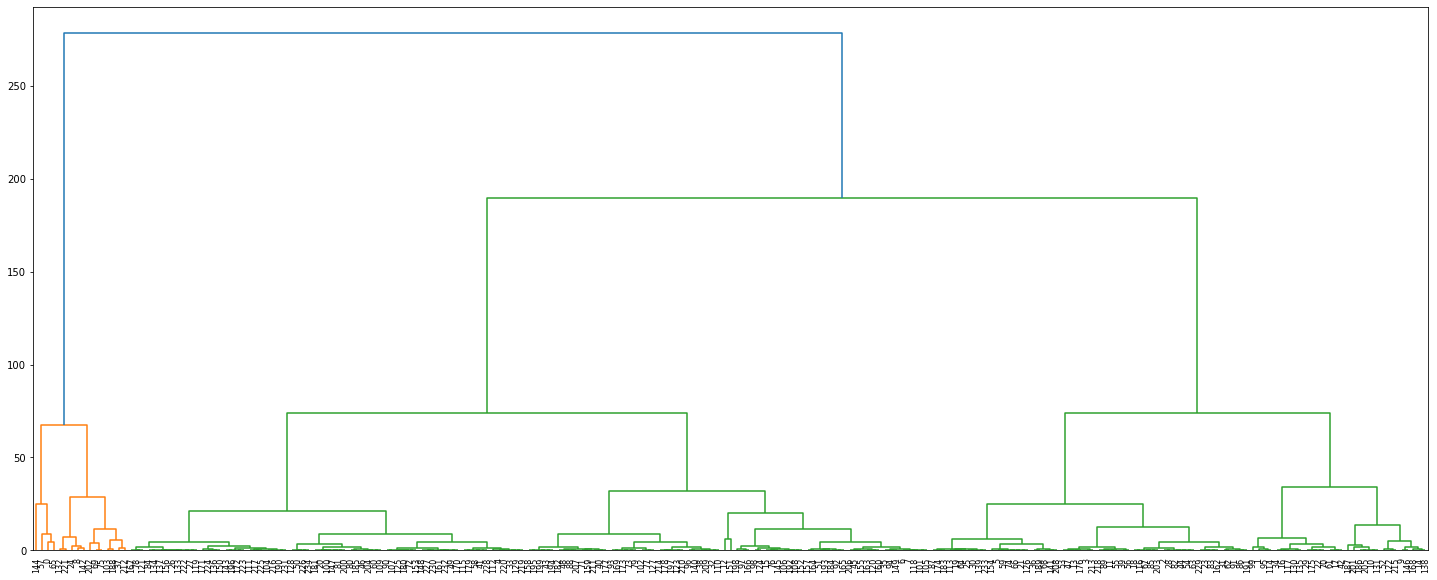

In [52]:
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.
)
plt.show()

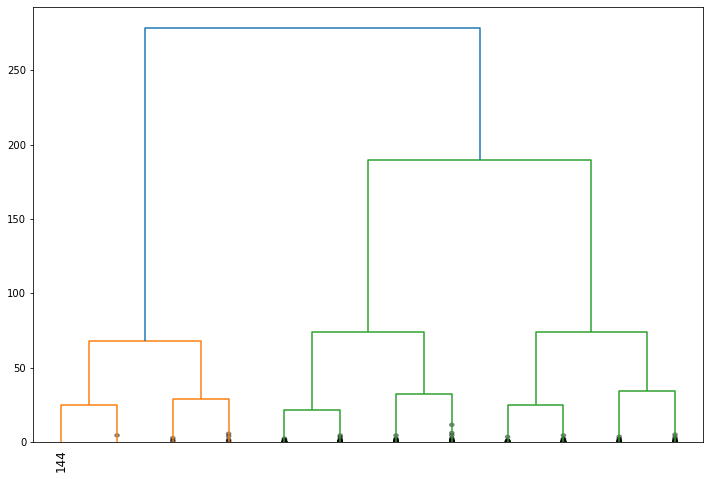

In [53]:
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p=12,
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.show()